We want to use a variational algorithm to find the eigenvalues of the observable:

$\hat{O}_1 = 2II - 2XX + 3YY - 3ZZ$

### Eigenvalues
$$
\lambda_0 = -6, \quad \lambda_1 = 4, \quad \lambda_2 = 4, \quad \lambda_3 = 6
$$

### Eigenstates
$$
\begin{aligned}
|\phi_0\rangle &= \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) \\
|\phi_1\rangle &= \frac{1}{\sqrt{2}} (|00\rangle - |11\rangle) \\
|\phi_2\rangle &= \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle) \\
|\phi_3\rangle &= \frac{1}{\sqrt{2}} (|01\rangle + |10\rangle)
\end{aligned}
$$

In [40]:
from qiskit.quantum_info import SparsePauliOp
 
observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

In [41]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
 
    return cost

In [42]:
from qgear.runner import expect_cudaq
def cost_func_vqe_cudaq(params, ansatz_template, hamiltonian, estimator):
    # Bind new parameters into the ansatz
    qc_bound = ansatz_template.assign_parameters(params)
    
    # Convert to CUDA-Q gate list
    gateD, md = qiskit_to_gateList([qc_bound])
    
    # Evaluate expectation value
    cost = expect_cudaq(gateD, hamiltonian, verb=0, backend="nvidia")
    return cost

/tmp/ipykernel_15883/1157548321.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  variational_form = TwoLocal(


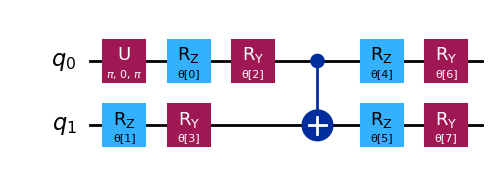

In [50]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
 
import numpy as np
 
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
 
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)
 

qc = raw_ansatz.decompose()
qc.draw("mpl")

In [44]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
 
estimator = Estimator()
sampler = Sampler()

In [45]:
x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [46]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time
 
start_time = time.time()
 
result = minimize(
    cost_func_vqe,
    x0,
    args=(raw_ansatz, observable_1, estimator),
    method="COBYLA",
    options={"maxiter": 1000, "disp": True},
)
 
end_time = time.time()
execution_time = end_time - start_time


   Normal return from subroutine COBYLA

   NFVALS =  137   F =-6.000000E+00    MAXCV = 0.000000E+00
   X = 1.739316E+00   9.302398E-01   1.570813E+00  -1.401860E-04   1.910029E+00
       1.231542E+00   6.225559E-01   6.224896E-01


In [47]:
from numpy.linalg import eigvalsh
 
solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))
 
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
 
print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)
print(solution_eigenvalue)
print(result.fun)

Number of iterations: 137
Time (s): 0.23997211456298828
Percent error: 1.04e-08
-6.0
-5.999999937584203


### qgear

In [51]:
from qgear.runner import qiskit_to_gateList
from cudaq import spin

# The CUDA Quantum version of the Qiskit SparsePauliOp
observable_1 = 2.0 - 2.0 * spin.x(0) * spin.x(1) + 3.0 * spin.y(0) * spin.y(1) - 3.0 * spin.z(0) * spin.z(1)
start_time = time.time()
result = minimize(
    cost_func_vqe_cudaq,
    x0,‹
    args=(qc, observable_1, estimator),
    method="COBYLA",
    options={"maxiter": 1000, "disp": True},
)
 
end_time = time.time()
execution_time = end_time - start_time

qiskit_to_gateList: nGate 10
     ╭───────────────────╮╭───────╮╭───────╮     ╭───────╮╭───────╮
q0 : ┤ u3(3.142,0,3.142) ├┤ rz(1) ├┤ ry(1) ├──●──┤ rz(1) ├┤ ry(1) ├
     ╰─────┬───────┬─────╯├───────┤╰───────╯╭─┴─╮├───────┤├───────┤
q1 : ──────┤ rz(1) ├──────┤ ry(1) ├─────────┤ x ├┤ rz(1) ├┤ ry(1) ├
           ╰───────╯      ╰───────╯         ╰───╯╰───────╯╰───────╯

qiskit_to_gateList: nGate 10
     ╭───────────────────╮╭───────╮╭───────╮     ╭───────╮╭───────╮
q0 : ┤ u3(3.142,0,3.142) ├┤ rz(2) ├┤ ry(1) ├──●──┤ rz(1) ├┤ ry(1) ├
     ╰─────┬───────┬─────╯├───────┤╰───────╯╭─┴─╮├───────┤├───────┤
q1 : ──────┤ rz(1) ├──────┤ ry(1) ├─────────┤ x ├┤ rz(1) ├┤ ry(1) ├
           ╰───────╯      ╰───────╯         ╰───╯╰───────╯╰───────╯

qiskit_to_gateList: nGate 10
     ╭───────────────────╮╭───────╮╭───────╮     ╭───────╮╭───────╮
q0 : ┤ u3(3.142,0,3.142) ├┤ rz(2) ├┤ ry(1) ├──●──┤ rz(1) ├┤ ry(1) ├
     ╰─────┬───────┬─────╯├───────┤╰───────╯╭─┴─╮├───────┤├───────┤
q1 : ──────┤ rz(2) ├──────┤

In [52]:
from numpy.linalg import eigvalsh
 
solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))
 
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
 
print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)
print(solution_eigenvalue)
print(result.fun)

Number of iterations: 126
Time (s): 0.15744328498840332
Percent error: 2.59e-07
-6.0
-5.999998445872498
